# Expérience basique
## filebench : filemicro_seqread
### Tester la high limite
#### Description
Le but de cette expérience est de lancer le benchmark `filebench` sans limite, avec une  `high` limite fixée à **1200MB** et avec une `high` limite fixée à **800MB**.

Le benchmark sera exécuté avec la charge de travail `filemicro_seqread` qui consiste à lire séquentiellement un fichier de 1024MB par pas de 1MB.

Chaque expérience consistera donc à exécuter le benchmark 10 fois pendant une minute afin d'obtenir un nombre moyen d'opérations par seconde "*stable*".

#### La `high` limite
La `high` limite (ou `max` limite) est une limite du `cgroup` mémoire. 

Lorsqu'un `cgroup` franchi cette limite il doit réclamer sa propre mémoire tant qu'il reste au dessus de cette limite de manière périodique.

#### Environnement 
Les conteneurs ont été lancés dans une machine virtuelle linux 4.19.5 disposant de 2GB de mémoire et 2 coeurs.

Les accès au disque de la machine virtuelle ne pouvaient pas compter sur le cache fichier du système hôte car celui-ci a été désactivé.

#### Résultats attendus
Puisque le fichier lu fait 1024MB dans le cas où la `high` limite est fixée à 1200MB il ne devrait pas y avoir de baisse de performance.

Par contre pour le cas où `high` limite est fixée à 800MB il est clair que le nombre d'opérations par seconde devrait être diminué.
On peut s'attendre à une diminution de 20% du nombre moyen d'opérations par seconde.

#### Algorithme de l'expérience
```bash
# Launch filebench container as detached and get its id.
id=$(docker run -d filebench) 

# Set the high limit of the container.
echo $size > /sys/fs/cgroup/memory/docker/$id/memory.high_limit_in_bytes

# Run the benchmark 10 times to compute mean and standard deviation.
for i in {1..10}; do
    docker exec $id ./filebench -f workloads/filemicro_seqread.f
done
```

#### Résultats obtenus
Le graphique suivant montre le nombre d'opérations par seconde moyen ainsi que son écart type pour les expériences réalisées :

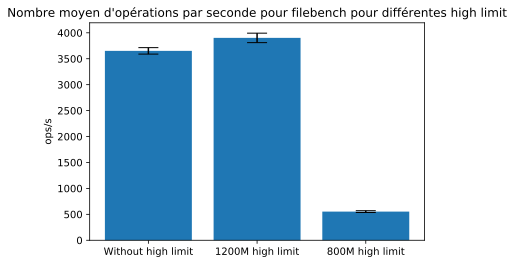

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

# lists for the bar chart.
means = []
stds = []

for file in ['without_high_limit.csv', '1200M_high_limit.csv', '800M_high_limit.csv']:
    # Get data from CSV file.
    df = pd.read_csv(file, ';')
    values = df.values

    # Computing mean and standard deviation.
    # values is a numpy.ndarray i.e an array of tuples.
    # mean() and std() take an axis as argument and return a tuple.
    # [1] permits to obtain second member of tuple.
    means.append(values.mean(0)[1])
    stds.append(values.std(0)[1])

# xtick labels for the bar chart.
names = ['Without high limit', '1200M high limit', '800M high limit']
# xtick for the bar chart.
x_pos = np.arange(len(names))

# Axis and figure initialization.
fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr = stds, align = 'center', capsize = 10)
ax.set_ylabel('ops/s')
ax.set_xticks(x_pos)
ax.set_xticklabels(names)
ax.set_title("Nombre moyen d'opérations par seconde pour filebench pour différentes high limit")

# Print the figure.
set_matplotlib_formats('svg')
plt.show()

Les résultats sont stables comme en témoignent les faibles valeurs des écart-types et ce malgré un message de `filebench` indiquant que la randomisation de l'espace d'adressage virtuel peut poser problème pour obtenir des expériences stables.

Le fait que les performances soient meilleures pour l'expérience avec une `high` limite fixée à 1200MB peut sembler curieux mais cela est sûrement lié à des variations normales d'une exécution à l'autre.

Dans tous les cas on peut voir que les résultats pour une limite fixée à 800MB sont bien inférieures à ceux obtenus sans limite (environ 500 opérations par seconde contre plus de 3500).

#### Conclusion
La `high` limite des conteneurs a bel et bien un effet sur les performances de ceux-ci.

Il semble donc intéressant de travailler sur celle-ci dans le but de la rendre plus intelligente si le conteneur n'arrive pas à obtenir les performances voulues si le système complet ne subit pas de pression mémoire.